# Wavelength recalibration with the sky lines (Mendel OH bands)

## Introduction

Data can be recalibrated in wavelength easily when one OH sky lines are visible in most parts of the field of view. Cubes observed in the red part of the spectrum (e.g. SN3 filter) are especially interesting in this respect. 

The general idea is to extract integrated spectra at different positions in the field of view and measure the velocity of the sky lines (which should be 0 if the calibration was perfect) (see [Martin et al. 2017a](https://arxiv.org/abs/1707.01366)). 

![skymap-fig0.svg](./skymap-fig0.svg)

Then the correction map can be infered at each pixel by fitting a model.

![skymap-fig1.svg](./skymap-fig1.svg)

The calibration model is based on a simple modeling of the interferometer.

![coords0.svg](./coords0.svg)

## First step: checking the calibration

In [1]:
# import base class for the manipulation of a SITELLE spectral cube: HDFCube
from orcs.process import SpectralCube
import pylab as pl

In [2]:
# load spectral cube
cube = SpectralCube('/home/thomas/M31_SN3.merged.cm1.1.0.hdf5')

master.fa09a|INFO| Cube is level 3
master.fa09a|INFO| shape: (2048, 2064, 840)
master.fa09a|INFO| wavenumber calibration: True
master.fa09a|INFO| flux calibration: True
master.fa09a|INFO| wcs calibration: True


(14500, 15500)

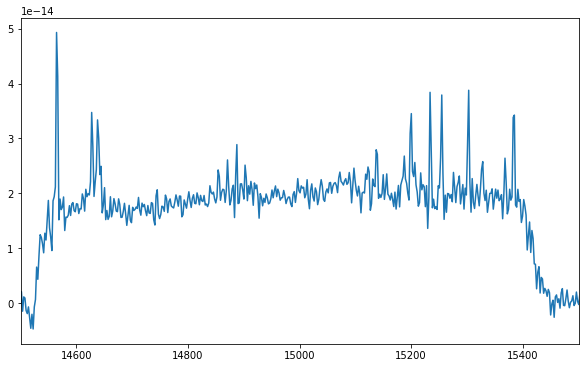

In [3]:
# extract and plot a spectrum of a large integrated region. Sky lines should be visible.
spectrum = cube.get_spectrum(50, 50, 20)
pl.figure(figsize=(10,6))
spectrum.plot()
pl.xlim(14500, 15500)

### fitting the sky spectrum

we can also fit the integrated spectrum because there si a large number of sky lines and because we are not interested in a perfect fit (only the velocity is required), we can use a simple 'sinc' model with a fixed fwhm. All the lines are set to share the same velocity parameter and we set an inital guess of the velocity around 80 km/s. This general bias of 80 km/s is known ([Martin et al. 2017b](https://arxiv.org/abs/1706.03230)) and comes from the error made on the real wavelength of the calibration laser (which is falsely considered to be at 453.5 nm).

Velocity:  77.5(1.5)


(14500, 15500)

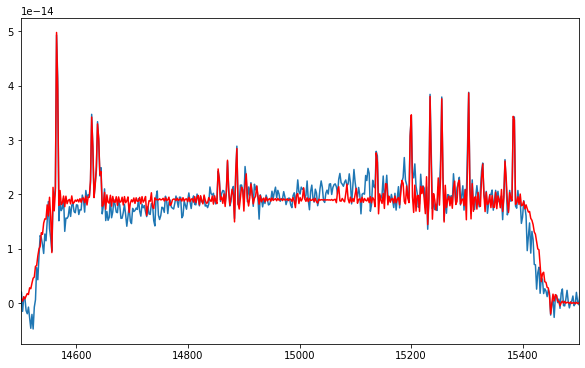

In [4]:
sky_lines_cm1 = cube.get_sky_lines()
fit_res = spectrum.fit(sky_lines_cm1,
                       fmodel='sinc',
                       pos_def='1',
                       fwhm_def='fixed',
                       nofilter=False,
                       pos_cov=80)

print('Velocity: ', fit_res['velocity_gvar'][0])
pl.figure(figsize=(10,6))
spectrum.plot()
fit_res.get_spectrum().plot(c='red')
pl.xlim(14500, 15500)

## Second step: Mapping the sky velocity

Warning: this process can take a long time because a spectrum is extracted and fitted for each point of a 40x40 grid by default. For a basic example it is recommended to limit the number of grid division to 10x10.

master.fa09a|INFO| fitting process already done ! set no_fit=True if you do not want to redo it
master.fa09a|INFO| X range: 0 2048, Y range: 0 2064
master.fa09a|INFO| Radius: 30
master.fa09a|INFO| excluding region from file m31_exclude.reg
master.fa09a|INFO| 58 regions to fit
master.fa09a|INFO| 88 sky lines to fit


 loading region: Shape : circle ( Number(1861.81818),Number(1876.36364),Number(30.00000) )



master.fa09a|INFO| Init of the parallel processing server with 32 threads


 [==========] [100%] [completed in 2m51s]                                     

master.fa09a|INFO| Closing parallel processing server


master.fa09a|INFO| parallel processing closed
master.fa09a|INFO| Velocity of the first line (km/s): 78.9(2.2)
master.fa09a|INFO| Velocity of the first line (km/s): 76.3(2.0)
master.fa09a|INFO| Velocity of the first line (km/s): 71.8(1.9)
master.fa09a|INFO| Velocity of the first line (km/s): 70.3(2.4)
master.fa09a|INFO| Velocity of the first line (km/s): 71.7(2.8)
master.fa09a|INFO| Velocity of the first line (km/s): 67.1(2.6)
master.fa09a|INFO| Velocity of the first line (km/s): 65.2(2.4)
master.fa09a|INFO| Velocity of the first line (km/s): 59.3(2.4)
master.fa09a|INFO| Velocity of the first line (km/s): 61.5(2.3)
master.fa09a|INFO| Velocity of the first line (km/s): 61.1(2.3)
master.fa09a|INFO| Velocity of the first line (km/s): 75.1(2.0)
master.fa09a|INFO| Velocity of the first line (km/s): 76.0(2.1)
master.fa09a|INFO| Velocity of the first line (km/s): 77.7(2.3)
master.fa09a|INFO| Velocity of the first line (km/s): 72.4(3.2)
master.fa09a|INFO| Velocity of the first line (km/s): 69.7

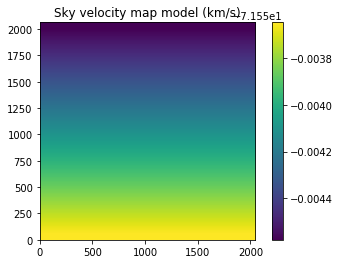

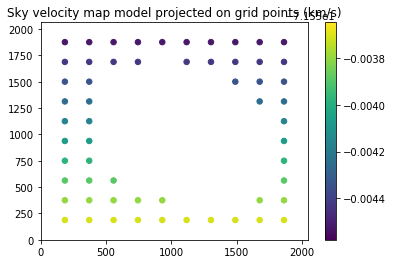

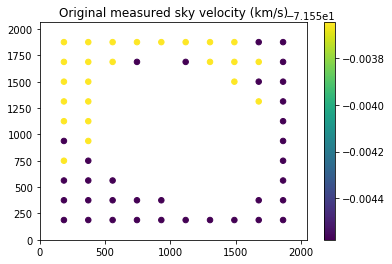

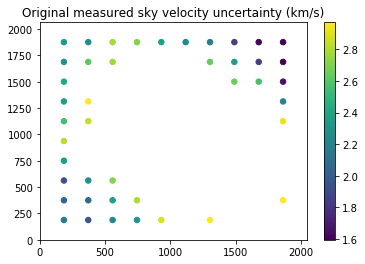

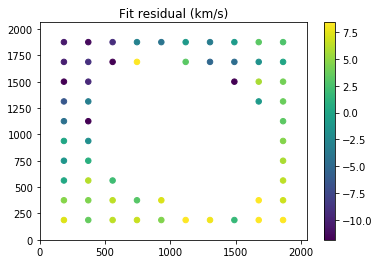

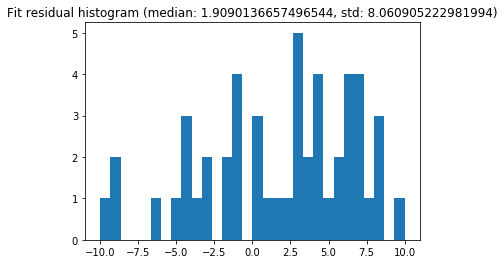

In [5]:
cube.map_sky_velocity(80, div_nb=10, exclude_reg_file_path='m31_exclude.reg') # the mean velocity bias is set around 80 km/s

## Ouputs

The most important output is the skymap which gives the modelized velocity of the sky in the field of view and permit to correct the measured velocities in the cube.This map is named `*skymap.fits`. You can add it to the obtained velocity maps to correct the velocity.

In this particular case this is `M31_SN3.1.0.ORCS/M31_SN3.1.0.skymap.fits`

The histogram above shows the difference between the measured velocity and the fitted velocity at each valid data point.

You can see that there are some data points at the center of the field which were excluded from the fit. This comes from the fact that M31 is very bright at the center and the sky lines are lost in the noise produced by the high continuum background. Modelling the interferometer makes possible to estimate the velocity of the lines at the center of the field where no velocity measurement could be done. And the result is stricking, it works particularly well even if the case of M31 ([Martin et al. 2017a](https://arxiv.org/abs/1707.01366))

